# Detection and Quantification in ISCAT

In this notebook we will investigate how to detect and quantify particles in ISCAT. 

The notebook contains the following sections:




## 1. Imports

In [1]:
import sys
sys.path.insert(0, "../") # Adds the module to path
import deeptrack as dt

In [2]:
import deeplay as dl

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import skimage # For detecting the centroids of the score map
import scipy
from scipy.optimize import minimize

## 2. Detection in ISCAT

Let's start by loading in data in the ISCAT regime.

In [4]:
data = np.load("../data/iscat_data.npy") #Quantitative field
labels = np.load("../data/iscat_labels.npy") #Labels for the particles
centroids = labels[:, 0:2] #Centroids of the particles

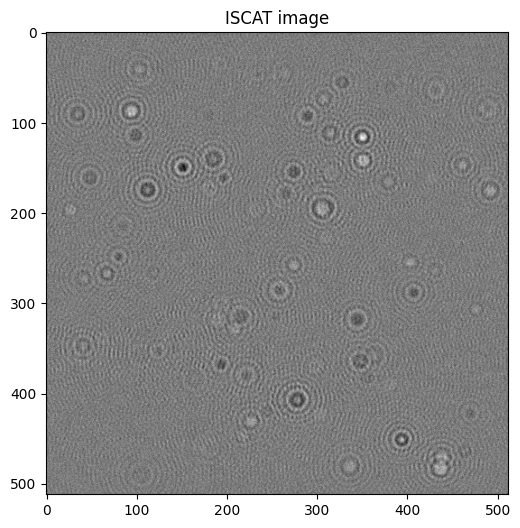

In [5]:
plt.figure(figsize=(6,6))
plt.imshow(data[...,0], cmap="gray")
plt.title("ISCAT image")
plt.show()

In [6]:
#Subtract 1 so data is centered around 0
data = data - 1

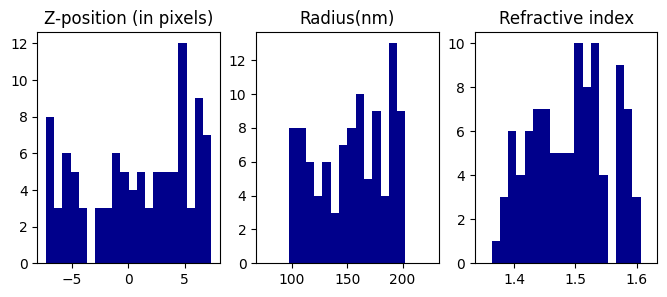

In [7]:
#Subplot of the distribution of the labels
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.hist(labels[:,2], bins=20, color = 'darkblue')
plt.title("Z-position (in pixels)")
plt.subplot(132)
plt.hist(labels[:,3]*1e9, bins=20, color = 'darkblue', range=(75, 225))
plt.title("Radius(nm)")
plt.subplot(133)
plt.hist(labels[:,4], bins=20, color = 'darkblue', range=(1.35, 1.62))
plt.title("Refractive index")
plt.show()


### 2.1 Detecting particles using a classical method


#### 2.1.1 - Radial Variance Transform
xxx

We construct a pipeline for the Radial Variance Transform(RVT) which also incorporates a local maxima step to detect the centroids of the particles.

In [8]:
import rvt # We import the radial variance method. Cite xxx

In [9]:
def rvt_pipeline(data, rmin = 4, rmax = 25, th_scale = 0.3, min_distance = 7, return_detection_map = False):
    """ Apply the Radial Variance Transform to the image and return the detections."""

    #Apply Radial Variance Transform of image
    det = rvt.rvt(data[...,0], rmin = rmin, rmax = rmax)

    #Local max of the transformed image.
    blobs = skimage.feature.peak_local_max(det, min_distance=min_distance)
    blobs = np.stack([blobs[:,0], blobs[:,1]], axis=-1)

    #Extract detections that have a high enough value
    detections = []
    th = np.mean(det)*th_scale
    for blob in blobs:
        if np.mean(det[blob[0]-2:blob[0]+2, blob[1]-2:blob[1]+2]) > th:
            detections.append(blob)

    #Convert to numpy array and rename
    detections_rvt = np.array(detections)

    if return_detection_map:
        return detections_rvt, det
    else:
        return detections_rvt

#### 2.1.2 - Visualizing the detections from RVT
xxx

In [10]:
###Settings for Radial Variance Transform pipeline
rmin, rmax = 5, 50
th_scale = 1
min_distance = 7

In [11]:
detections_rvt = rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance)

Text(0.5, 1.0, 'Detections with Radial Variance Transform')

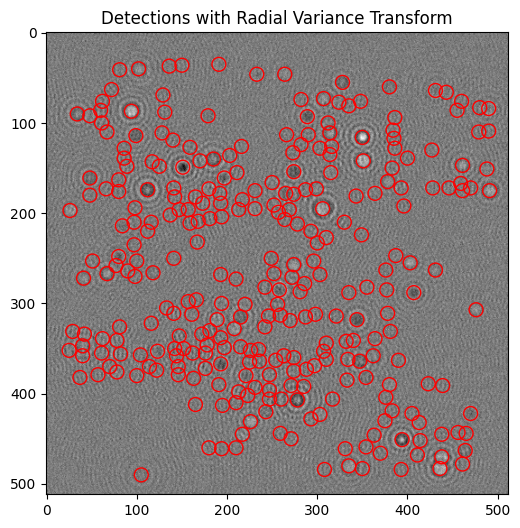

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(data[...,0], cmap="gray")
plt.scatter(detections_rvt[:,1], detections_rvt[:,0], s = 100, facecolors='none', edgecolors='r')
plt.title("Detections with Radial Variance Transform") 

#### 2.1.3 - Optimizing the parameters for the RVT pipeline

xxx

In [13]:
radius = 6 # Radius of the particle in pixels
centroids = labels[:, :2] # We use the labels as the ground truth
mask = np.zeros_like(data[...,0])

In [14]:
def add_bin_circles(positions, radius, image):
    """Add circles to an image."""
    im = image.copy()
    
    if len(positions) == 0:
        return im
    
    for position in positions:
        rr, cc = skimage.draw.disk(position, radius)
        im[rr, cc] = 1
    return im

In [15]:
GT_particles = add_bin_circles(centroids, radius, mask)

Text(0.5, 1.0, 'Ground truth particles')

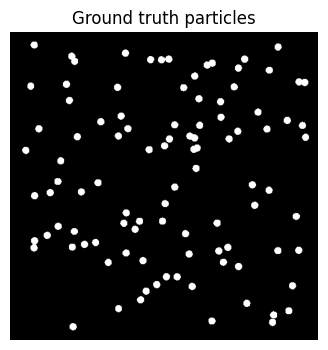

In [16]:
plt.figure(figsize=(4, 4))
plt.imshow(GT_particles, cmap="gray")
plt.axis("off")
plt.title("Ground truth particles")

In [17]:
def get_F1_score(Pred_Particles, GT_particles):
    """Get the F1 score between the predicted particles and the ground truth."""
    # True positives - Overlap between the mask and the ground truth
    TP = np.sum(Pred_Particles * GT_particles)
    # False positives - Detections that are not in the ground truth
    FP = np.sum(Pred_Particles) - TP
    # False negatives - Ground truth particles that were not detected
    FN = np.sum(GT_particles) - TP

    # F1 score
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

def objective(params):
    """Objective function for the optimization of the Radial Variance Transform pipeline."""

    rmin, rmax, th_scale, min_distance = params

    detections = rvt_pipeline(data, rmin = round(rmin), rmax = round(rmax), th_scale = th_scale, min_distance = round(min_distance))

    #Remove detections that are too close to the border with size radius
    if len(detections) > 0:
        detections = detections[(detections[:,0] > radius) & (detections[:,0] < data.shape[0] - radius) & 
                                (detections[:,1] > radius) & (detections[:,1] < data.shape[1] - radius)]

    # We create the mask with the detections
    mask_tmp = add_bin_circles(detections, radius, mask)

    # We calculate the F1 score
    F1 = get_F1_score(mask_tmp, GT_particles)

    return -F1


In [18]:
OPTIMIZE = True

# Initial guess for the parameters
initial_guess = [5, 50, 1, 7]

# Bounds for the parameters
bounds = [(1, 15), (15, 60), (0, 5), (3, 12)]

max_iter = 1000  # Maximum number of iterations

if OPTIMIZE:
    # Perform optimization
    result = minimize(objective, initial_guess, method='Nelder-Mead', bounds = bounds, tol=5e-1, options={'maxiter': max_iter})

    # Get the optimized parameters
    optimized_params = result.x
    print("Optimized parameters:", optimized_params)

    # Get the minimized value (objective function value at the optimal point)
    minimized_value = result.fun
    print("Minimized value:", minimized_value)

    # Get the optimized parameters
    rmin, rmax, th_scale, min_distance = optimized_params
    rmin, rmax, th_scale, min_distance = round(rmin), round(rmax), th_scale, round(min_distance)
    print("Optimized parameters:", rmin, rmax, th_scale, min_distance)


Optimized parameters: [ 5.09790606 30.71697846  1.94714676  7.59044512]
Minimized value: -0.6960059538576036
Optimized parameters: 5 31 1.9471467569470442 8


In [19]:
detections_rvt = rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance)

Text(0.5, 1.0, 'Detections with RVT and optimized threshold')

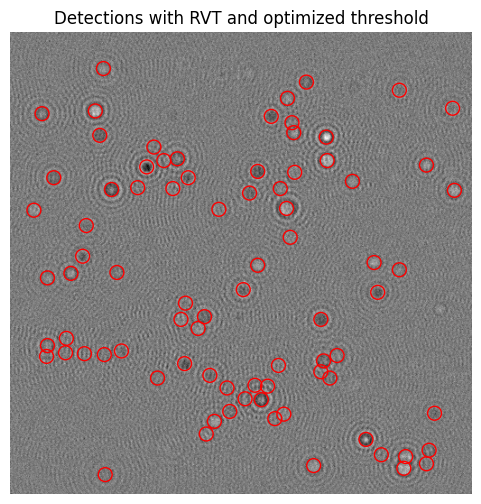

In [20]:
### For RVT
plt.figure(figsize=(6,6))
plt.imshow(data[...,0], cmap="gray")
plt.scatter(detections_rvt[:,1], detections_rvt[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis('off')
plt.title("Detections with RVT and optimized threshold")

In [21]:
F1_score_rvt = get_F1_score(add_bin_circles(detections_rvt, radius, mask), GT_particles)
print("F1 score for RVT:", F1_score_rvt)

F1 score for RVT: 0.6960059538576036


### 2.2 Detecting particles using LodeSTAR model

xxx

#### 2.2.1  Prepare the Training Crop
We will use a set of crops for a few particles to train the neural network.

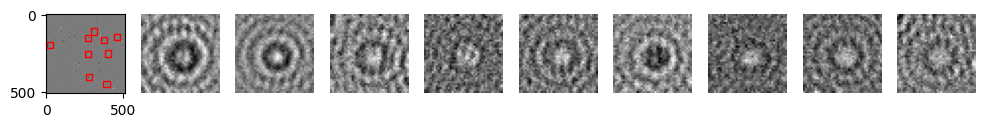

In [123]:
import matplotlib.patches as patches

crop_size = 40
labels_idx = [33, 11, 0, 44, 99, 63, 84, 19, 50]

# We crop the image around the particle (based on the labels) - One could also use the detections or manually select a particle.
crop_x0s = np.array([int(labels[label_idx, 0] - crop_size/2) for label_idx in labels_idx])
crop_y0s = np.array([int(labels[label_idx, 1] - crop_size/2) for label_idx in labels_idx])

crops = np.array([data[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size, :] for crop_x0, crop_y0 in zip(crop_x0s, crop_y0s)])

plt.figure(figsize=(12, 6))

plt.subplot(1, len(labels_idx)+1, 1)
plt.imshow(data[...,0], cmap="gray")

for crop_x0, crop_y0 in zip(crop_x0s, crop_y0s):
    plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                        linewidth=1, edgecolor="r",
                                        facecolor="none"))

for i, crop in enumerate(crops):
    plt.subplot(1, len(labels_idx)+1, 2+i)
    plt.imshow(crop[...,0], cmap="gray")
    plt.axis('off')

plt.show()

#### 2.2.2  Prepare pipeline and train model
We will create a pipeline for training the LodeSTAR model

In [23]:
x,y=np.meshgrid(
    np.arange(crop_size)-crop_size,
    np.arange(crop_size)-crop_size
    )

def grad(dx1, dy1):
    def inner(image):
        image[...,0]+=dx1*x+dy1*y
        return image
    return inner

addgrad=dt.Lambda(
    grad,
    dx1=lambda: .01/40*np.random.randn(),
    dy1=lambda: .01/40*np.random.randn(),
    )

In [24]:
training_pipeline = (
    dt.Value(lambda: crops[np.random.randint(len(crops))])
    >> addgrad
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 5e-3)
    >> dt.Multiply(lambda: np.random.uniform(-2, 2))
    >> dt.Add(lambda: np.random.uniform(-0.5, 0.5))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, replace=False)

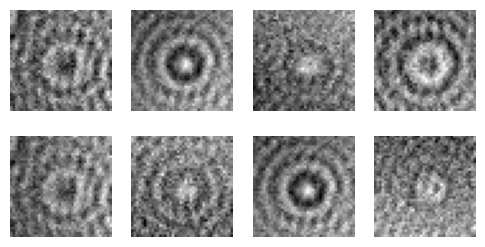

In [25]:
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(6, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,0], cmap="gray")
    plt.axis("off")

In [26]:
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=2e-4)).build()
trainer = dl.Trainer(max_epochs=200)
trainer.fit(lodestar, dataloader)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------

Epoch 199: 100%|██████████| 50/50 [00:03<00:00, 13.01it/s, v_num=75, train_between_image_disagreement_step=0.438, train_within_image_disagreement_step=0.0352, train_between_image_disagreement_epoch=0.440, train_within_image_disagreement_epoch=0.0375]


#### 2.2.3  Visualize result from trained LodeSTAR model

xxx

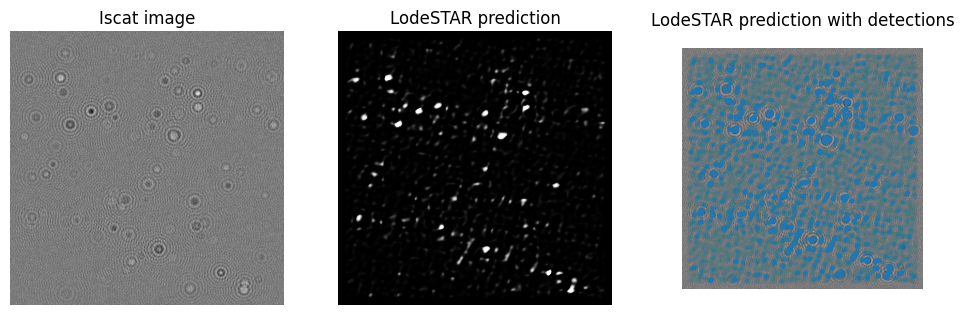

In [27]:

torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Iscat image")
plt.imshow(data[...,0], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("LodeSTAR prediction")
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("LodeSTAR prediction with detections")
plt.imshow(data[...,0], cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

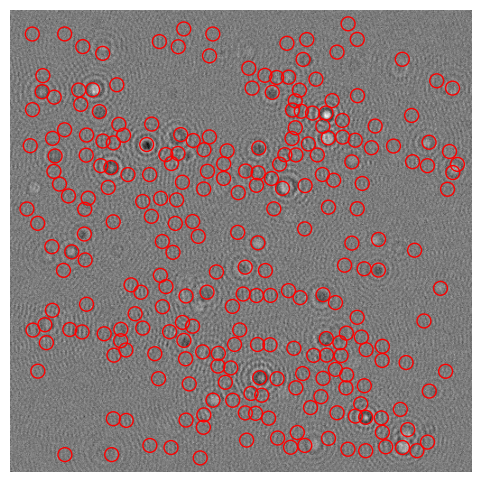

In [28]:
alpha = 0.5
beta = 0.5
cutoff = 0.95
mode = "quantile"#"constant"

plt.figure(figsize=(6, 6))
torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                mode=mode, cutoff=cutoff)[0]

plt.imshow(data[...,0], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis("off")

plt.show()

#### 2.2.4 Optimize the parameters for the LodeSTAR model

In [29]:
def objective_l(params):
    """Objective function for the optimization of the LodeSTAR pipeline."""

    beta, cutoff = params

    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=1-beta, beta=beta, 
                                mode="quantile", cutoff=cutoff)[0]

    #Remove detections that are too close to the border with size radius
    if len(detections) > 0:
        detections = detections[(detections[:,0] > radius) & (detections[:,0] < data.shape[0] - radius) & 
                                (detections[:,1] > radius) & (detections[:,1] < data.shape[1] - radius)]

    # We create the mask with the detections
    mask_tmp = add_bin_circles(detections, radius, mask)

    # We calculate the F1 score
    F1 = get_F1_score(mask_tmp, GT_particles)
    return -F1

In [30]:
OPTIMIZE = True

# Initial guess for the parameters
initial_guess = [0.5, 0.95]  # Example initial guess

# Bounds for the parameters
bounds = [(0, 1), (0.8, 1)]  # Example bounds

max_iter = 1000  # Maximum number of iterations

if OPTIMIZE:
    # Perform optimization
    result = minimize(objective_l, initial_guess, method='Nelder-Mead', bounds = bounds, options={'maxiter': max_iter})

    # Get the optimized parameters
    optimized_params = result.x
    print("Optimized parameters:", optimized_params)

    # Get the minimized value (objective function value at the optimal point)
    minimized_value = result.fun
    print("Minimized value:", minimized_value)

    # Get the optimized parameters
    beta, cutoff = optimized_params
    alpha = 1-beta
    print("Optimized parameters:", alpha, beta, cutoff)


Optimized parameters: [0.46622925 0.99093628]
Minimized value: -0.2989195057643592
Optimized parameters: 0.533770751953125 0.46622924804687504 0.9909362792968748


In [31]:
detections_l = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                                mode="quantile", cutoff=cutoff)[0]

Text(0.5, 1.0, 'Detections with LodeSTAR and optimized threshold')

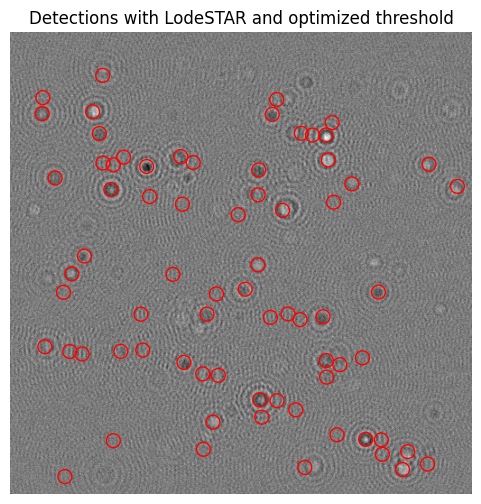

In [32]:
### For RVT
plt.figure(figsize=(6,6))
plt.imshow(data[...,0], cmap="gray")
plt.scatter(detections_l[:,1], detections_l[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis('off')
plt.title("Detections with LodeSTAR and optimized threshold")

In [33]:
# F1 score for LodeSTAR
F1_score_l = get_F1_score(add_bin_circles(detections_l, radius, mask), GT_particles)
print("F1 score for LodeSTAR:", F1_score_l)

F1 score for LodeSTAR: 0.2989195057643592


## 3 - Quantification of particle properties in ISCAT

xxx

In [34]:
padsize = 20 # Padding size, 20 pixels gives a total size of 40x40 pixels.

In [89]:
def get_rois(data, positions, padsize):
    """Function for retrieving ROIs from data. Obs - rounded to integers"""

    rois = []
    for pos in positions:
        #Check if the roi is out of bounds
        if pos[1]-padsize < 0 or pos[1]+padsize >= data.shape[0] or pos[0]-padsize < 0 or pos[0]+padsize >= data.shape[1]:
            continue

        roi = data[int(pos[0]-padsize):int(pos[0]+padsize), int(pos[1]-padsize):int(pos[1]+padsize),:]
        
        rois.append(roi)
    return np.stack(rois)

In [90]:
rois = get_rois(data, centroids, padsize)

In [93]:
def get_polarizability_rr(radius, refractive_index):
    """Calculate the polarizability of a particle."""
    return np.array(4/3 * np.pi * radius**3 * (refractive_index - 1.33))

def form_factor(radius, nm=1.333, wavelength = 532):
    k = (2 * np.pi * nm) / wavelength 
    q = 2 * k * np.sin(np.pi/2) 
    return 3 / (q*radius)**3 *((np.sin(q*radius) - q*radius*np.cos(q*radius)))

def signal_iscat(form_factor, polarizability):
    return np.abs(form_factor) * polarizability

In [92]:
# Calculate the polarizabilities for all the particles
polarizabilities_rois = get_polarizability_rr(labels[:,3], labels[:,4])
form_factors = form_factor(labels[:,3]*1e9, wavelength = 532)
signal_rois = np.array([signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, polarizabilities_rois)])

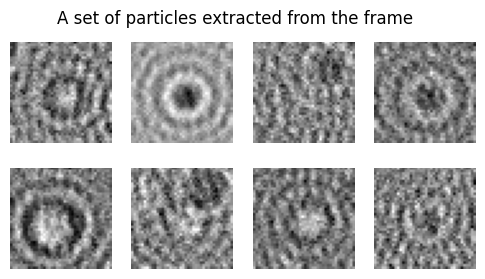

In [39]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of particles extracted from the frame")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(rois[i,...,0], cmap="gray")
    plt.axis("off")

### 3.1 Quantifying particle signal with a classical method

To quantify the particles we perform the Radial Variance Transform on the ROIs followed by a gaussian fit, which is then either followed by a weighted sum of the input image or returning the "integral" of the gaussian fit.

In [40]:
def gaussian_fit(input_data, upscale = 1, binary_gauss = False, return_integral = False):
    """Fit a 2D Gaussian to the input data and return the Gaussian values."""

    # Get the dimensions of the image
    height, width = input_data.shape

    # Upscale the input data
    input_data = input_data*upscale

    # Create meshgrid for the image coordinates
    x, y = np.meshgrid(np.arange(0, width)-width/2, np.arange(0, height)-height/2)

    # Stack the meshgrid coordinates
    data = np.column_stack((x.flatten(), y.flatten()))

    # Fit a 2D Gaussian distribution to the pixel intensity values
    fitf = lambda x, a, b, c, d, e: a*np.exp(-((x[:,0]-b)**2+(x[:,1]-c)**2)/(2*d**2))+e

    # Fit the Gaussian to the data
    f = scipy.optimize.curve_fit(
        fitf,
        data,
        input_data.flatten()-np.mean(input_data.flatten()),
        p0=[1*upscale, 0, 0, 1, 0],
        bounds=((-1*upscale, -5, -5, .1, -1), ((1*upscale, 5, 5, 100, 1))))

    # Calculate the Gaussian values
    gaussian_values = f[0][0]*np.exp(-((x-f[0][1])**2+(y-f[0][2])**2)/(2*f[0][3]**2))+f[0][4]

    # Binarize the Gaussian values
    if binary_gauss:
        gaussian_values = gaussian_values > np.mean(gaussian_values)*4

    # Return the integral of the Gaussian values
    if return_integral:
        return np.abs(f[0][0] * f[0][3]**2 * np.sqrt(2*np.pi)) / upscale

    return gaussian_values

def radial_variance_gaussian(input_data, rmin = 3, rmax = 20, binary_gauss=False, return_integral = False):
    """Creates a score map with Radial Variance Transform and fits a 2D Gaussian to the data. Returns the weighted sum of the pixel values or the integral of the Gaussian."""

    # Apply the Radial Variance Transform to the input data (imaginary part)
    input_data_rvt = rvt.rvt(input_data[...,0], rmin = rmin, rmax = rmax)

    # Fit a 2D Gaussian distribution to the pixel intensity values
    gaussian_values = gaussian_fit(input_data_rvt, binary_gauss=binary_gauss, return_integral=return_integral)

    # Sum the pixel values weighted by the Gaussian values
    if not return_integral:
        return np.abs(np.sum(input_data[...,0] * gaussian_values))

    return np.sum(gaussian_values)**(1/2)

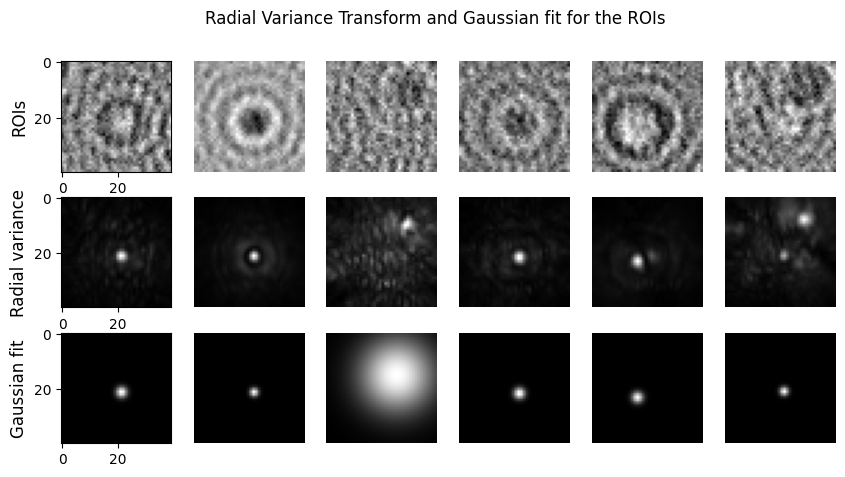

In [41]:
det_map = np.array([rvt.rvt(roi[...,0], rmin = rmin, rmax = rmax) for roi in rois])
gaussian_map = np.array([gaussian_fit(det) for det in det_map])

plt.figure(figsize=(10, 5))
plt.suptitle("Radial Variance Transform and Gaussian fit for the ROIs")
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.imshow(rois[i][...,0], cmap="gray")
    if i == 0: plt.ylabel("ROIs", fontsize=12)
    else: plt.axis("off")
for i in range(6):
    plt.subplot(3, 6, i+7)
    plt.imshow(det_map[i], cmap="gray")
    if i == 0: plt.ylabel("Radial variance", fontsize=12)
    else: plt.axis("off")
for i in range(6):
    plt.subplot(3, 6, i+13)
    plt.imshow(gaussian_map[i], cmap="gray")
    if i == 0: plt.ylabel("Gaussian fit", fontsize=12)
    else: plt.axis("off")

In [94]:
signal_sum_gauss = np.array([radial_variance_gaussian(roi, binary_gauss=True) for roi in rois])

Text(0.5, 1.0, 'Theoretical Signal vs. Signal estimated RVT and gaussian fit')

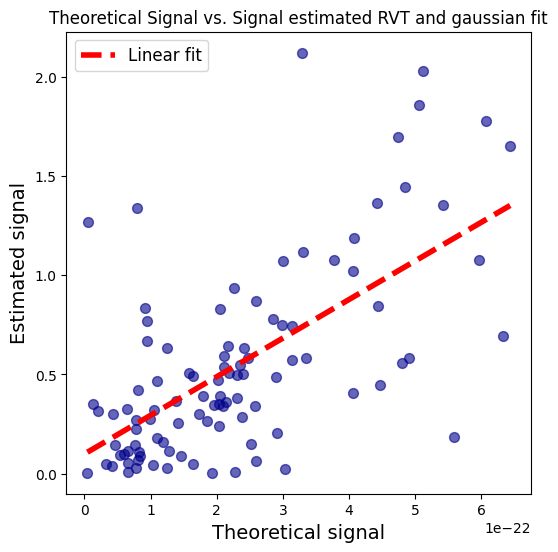

In [95]:
plt.figure(figsize=(6, 6))
plt.scatter(signal_rois, signal_sum_gauss, color="darkblue", alpha=0.6, s=50)
#line fit
coefficients = np.polyfit(signal_rois, signal_sum_gauss, 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(signal_rois.min(), signal_rois.max(), 100)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, color="red", linestyle="--", linewidth=4, label="Linear fit")
plt.xlabel("Theoretical signal", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical Signal vs. Signal estimated RVT and gaussian fit")

Text(0.5, 0, 'Refractive index')

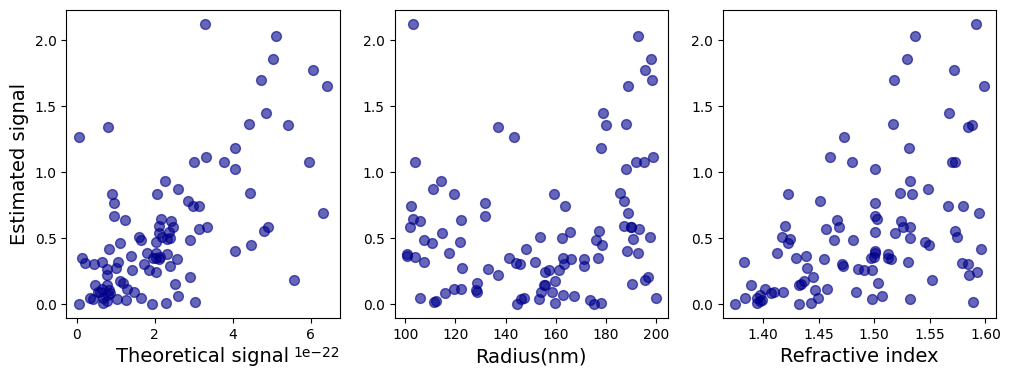

In [96]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(signal_rois, signal_sum_gauss, color="darkblue", alpha=0.6, s=50)
plt.xlabel("Theoretical signal", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.subplot(132)
plt.scatter(labels[:,3]*1e9, signal_sum_gauss, color="darkblue", alpha=0.6, s=50)
plt.xlabel('Radius(nm)', fontsize=14)
plt.subplot(133)
plt.scatter(labels[:,4], signal_sum_gauss, color="darkblue", alpha=0.6, s=50)
plt.xlabel('Refractive index', fontsize=14)
#theoretical_signal

In [45]:
#Find a fit that converts signal
coefficients = np.polyfit(signal_sum_gauss, signal_rois, 1)
polynomial = np.poly1d(coefficients)

#Predict
signal_pred = polynomial(signal_sum_gauss)

#Compute MSE, MAE
mse_g = np.mean((signal_rois - signal_pred)**2)
mae_g = np.mean(np.abs(signal_rois - signal_pred))

print(f"MSE: {mse_g}")
print(f"MAE: {mae_g}")


MSE: 5.605193857299268e-44
MAE: 1.9608247253245351e-22


### 3.2 Quantifying particle signal using a 2DCNN

#### 3.2.1 Defining the optical system

xxx

In [46]:
IMAGE_SIZE = 40
NA = 1.3
MAGNIFICATION = 1
WAVELENGTH = 633e-9
RESOLUTION = 1.14e-7

In [47]:
optics = dt.ISCAT(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination_angle=np.pi,
)

#### 3.2.2 Defining the particle(s)

In [48]:
RADIUS_RANGE = (25e-9, 250e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [49]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 5,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
    
)

#### 3.2.3 Create dataset of particles

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [50]:
noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.0025*np.random.rand(),
)

We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [51]:
sample = optics(particle >> noise) >> dt.Subtract(1)

noisy_dataset = sample >> dt.Gaussian(sigma=0.0025)
clean_dataset = dt.Bind(sample, z=0, position_objective=(0,0,0))

dataset = noisy_dataset & clean_dataset

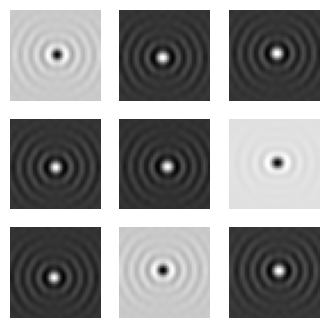

In [52]:
#3x3 grid of augmented images
plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = dataset.update().resolve()
    plt.imshow(img[1][...,0], cmap="gray")
    plt.axis('off')

#### 3.2.4 Defining the training label

We extract the parameters we want the network to learn. This is the integrated signal.

In [53]:
def get_label():
    "Label function for the dataset. We sum the image"
    def inner(image):
        return np.expand_dims(np.array(np.sum(np.abs(image))), -1)
    return inner
def get_batch():
    "Batch function for the dataset."
    def inner(image):
        return image
    return inner

#### 3.2.5 Defining quantification model (2DCNN)
xxx

In [54]:
conv = dl.ConvolutionalNeuralNetwork(
    in_channels = 1, 
    hidden_channels=[32, 64], 
    out_channels = 64,
    pool = dl.torch.nn.MaxPool2d(kernel_size=2),
    out_activation=dl.torch.nn.ReLU
    )

mlp = dl.MultiLayerPerceptron(None, [64, 32], 1)

net = dl.Sequential(
    conv,
    mlp
)

In [55]:
regressor = dl.Regressor(
    model=net,
    loss=dl.torch.nn.MSELoss(),
    optimizer=dl.Adam(),
)
cnn_regressor = regressor.create()

#### 3.2.6 Training of the model
xxx

In [56]:
#Pipeline for generating images and labels.
image_and_signal_pipeline = noisy_dataset & clean_dataset >> dt.Lambda(get_label) #dataset #(dataset >> dt.Lambda(get_batch)) & (dataset >> dt.Lambda(get_label))

In [57]:
training_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=1000, replace=False)

dataloader = dl.DataLoader(training_dataset, batch_size=16, shuffle=True)

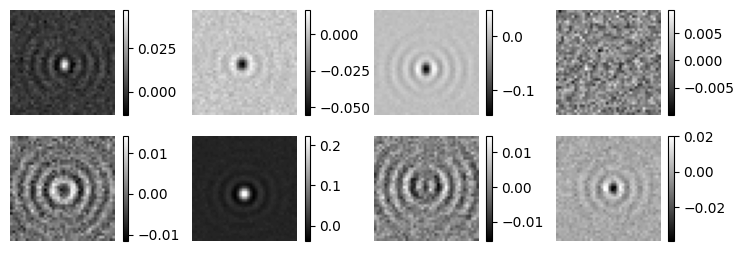

In [58]:
batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(9, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,0], cmap="gray")
    plt.colorbar()
    plt.axis("off")

In [59]:
trainer = dl.Trainer(max_epochs=1000)
trainer.fit(cnn_regressor, dataloader)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 57.9 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
57.9 K    Trainable params
0         Non-trainable params
57.9 K    Total params
0.231     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val

Epoch 499: 100%|██████████| 63/63 [00:00<00:00, 70.66it/s, v_num=76, train_loss_step=0.00324, train_loss_epoch=0.00565] 


#### 3.2.7 Validating the model on simulated data and ROIs from frame.
xxx


In [60]:
#Generate new data.
val_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=200)
val_dataloader = dl.DataLoader(val_dataset, batch_size=16, shuffle=True)

#Predict the signal
predictions = []
labels_ = []
for batch in val_dataloader:
    predictions.append(cnn_regressor(batch[0]).detach().numpy())
    labels_.append(batch[1].detach().numpy())

#Concatenate the predictions and labels
predictions = np.concatenate(predictions)[:, 0]
labels_ = np.concatenate(labels_)[:, 0]


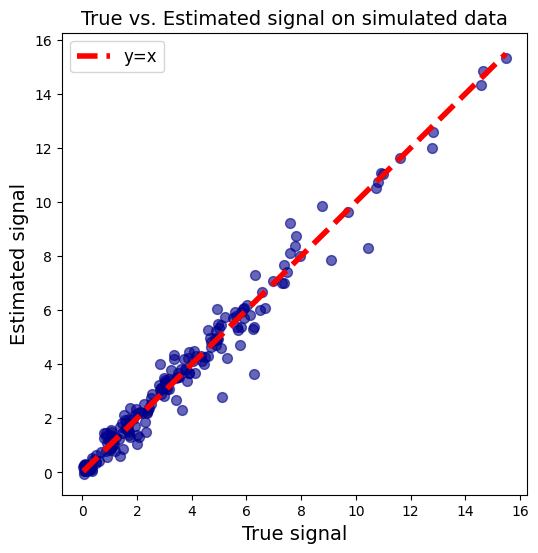

In [61]:
plt.figure(figsize=(6, 6))
plt.scatter(labels_, predictions, color="darkblue", alpha=0.6, s=50)
#y=x line
plt.plot([np.min(labels_), np.max(labels_)], [np.min(labels_), np.max(labels_)], color="red", linestyle="--", linewidth=4, label="y=x")
plt.xlabel("True signal", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("True vs. Estimated signal on simulated data", fontsize=14)
plt.show()


In [97]:
#Predict on the rois
predictions_rois = [cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float()) for roi in rois]
predictions_rois = np.array([pred.detach().numpy()[0, 0] for pred in predictions_rois])

Text(0.5, 1.0, 'Theoretical Signal vs. Signal estimated with CNN on ROIs')

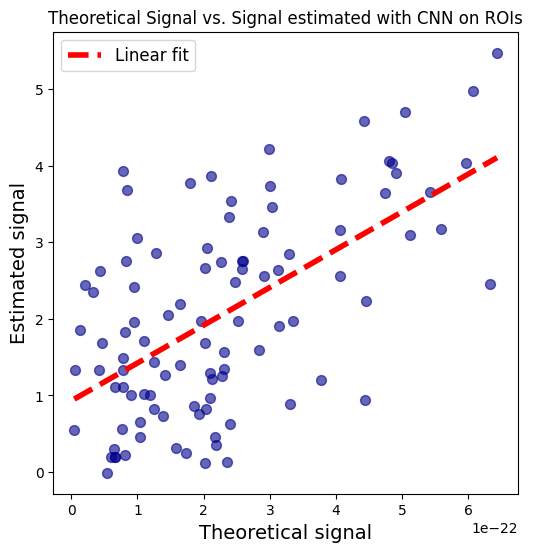

In [98]:
plt.figure(figsize=(6, 6))
plt.scatter(signal_rois, predictions_rois, color="darkblue", alpha=0.6, s=50)
#line fit
coefficients = np.polyfit(signal_rois, predictions_rois, 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(signal_rois.min(), signal_rois.max(), 100)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, color="red", linestyle="--", linewidth=4, label="Linear fit")
plt.xlabel("Theoretical signal", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical Signal vs. Signal estimated with CNN on ROIs")

In [99]:
# Find linear fit that converts signal
coefficients = np.polyfit(predictions_rois, signal_rois, 1)
polynomial = np.poly1d(coefficients)

# Predict
predictions_pred = polynomial(predictions_rois)

# Compute MSE, MAE
mse_cnn = np.mean((signal_rois - predictions_pred)**2)
mae_cnn = np.mean(np.abs(signal_rois - predictions_pred))

print(f"MSE: {mse_cnn}")
print(f"MAE: {mae_cnn}")

MSE: 1.5414283107572988e-44
MAE: 1.0088697309572103e-22


### 3.4 Investigating the signal as dependence while keeping either refractive index or radius fixed.

#### 3.4.1 Fix refractive index 

In [100]:
FIX_RI = 1.4
RADIUS_RANGE = np.linspace(25e-9, 250e-9, 100)
samples_per_case = 10
data_case = 'noisy'
radiuses = np.concatenate([np.repeat(x, samples_per_case) for x in RADIUS_RANGE])

In [101]:
DATA = []
for i, rad in enumerate(RADIUS_RANGE):
    if i % 10 == 0:
        print(f"Currently at {i}/{len(RADIUS_RANGE)}")

    particle = dt.MieSphere(
        position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
        z=lambda: np.random.randn() * 5,
        radius=lambda: rad,
        refractive_index=lambda: FIX_RI,
        L=8,
        position_unit="pixel",
    )

    #Define the noise and optical system
    if data_case == 'noisy':
       dataset = optics(particle >> noise) >> dt.Gaussian(sigma=0.0025)
    else:
        dataset = optics(particle)

    #Get the particles
    for _ in range(samples_per_case):
        DATA.append(
            dataset.update().resolve()
        )
DATA = np.array(DATA)

Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [102]:
# Get the theoretical polarizabilities
theoretical_pol = get_polarizability_rr(radiuses, FIX_RI)
form_factors = form_factor(radiuses*1e9, wavelength = 532)
theoretical_signal = np.array([signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, theoretical_pol)])

In [103]:
signal_sum_gauss_fix_ri = np.array([radial_variance_gaussian(roi,binary_gauss=True) for roi in DATA])

In [104]:
signal_sum_cnn_fix_ri = cnn_regressor(torch.from_numpy(DATA).permute(0, 3, 1, 2).float()).detach().numpy()[:, 0]

In [105]:
#Normalize the signals
signal_sum_gauss_fix_ri = (signal_sum_gauss_fix_ri - signal_sum_gauss_fix_ri.min()) / (signal_sum_gauss_fix_ri.max() - signal_sum_gauss_fix_ri.min())
signal_sum_cnn_fix_ri = (signal_sum_cnn_fix_ri - signal_sum_cnn_fix_ri.min()) / (signal_sum_cnn_fix_ri.max() - signal_sum_cnn_fix_ri.min())
theoretical_signal = (theoretical_signal - theoretical_signal.min()) / (theoretical_signal.max() - theoretical_signal.min())

Text(0.5, 1.0, 'Theoretical Signal vs. Signal with RVT and gaussian fit on ROIs')

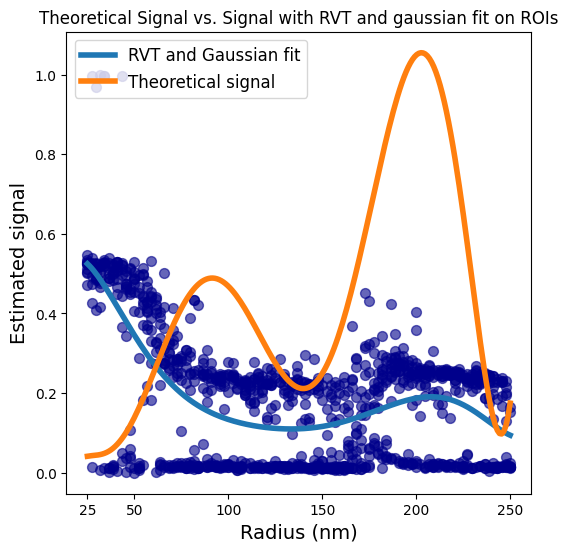

In [106]:
plt.figure(figsize=(6, 6))
plt.scatter(radiuses, signal_sum_gauss_fix_ri, color="darkblue", alpha=0.6, s=50)

x_axis = np.linspace(radiuses.min(), radiuses.max(), 200)

#Polynomial line for gaussian and RVT fit
coefficients = np.polyfit(radiuses, signal_sum_gauss_fix_ri, 7)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="-", linewidth=4, label="RVT and Gaussian fit")

#Polynomial line for theoretical
coefficients = np.polyfit(radiuses, theoretical_signal, 7)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="-", linewidth=4, label="Theoretical signal")

plt.xticks([25e-9, 50e-9, 100e-9, 150e-9, 200e-9, 250e-9], ["25", "50", "100", "150", "200", "250"])

plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical Signal vs. Signal with RVT and gaussian fit on ROIs")

Text(0.5, 1.0, 'Theoretical Signal vs. Signal estimated with a 2DCNN')

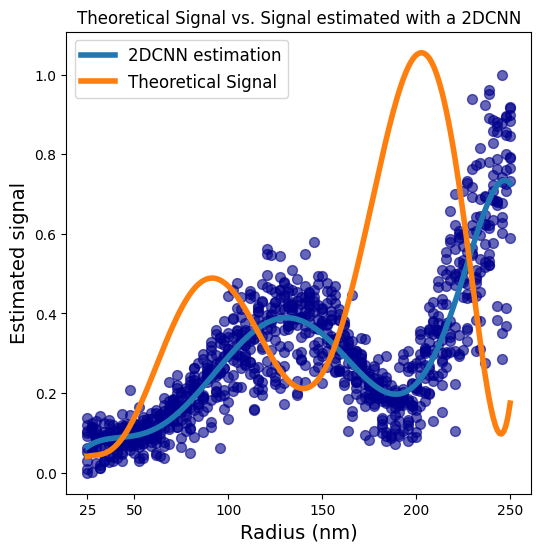

In [107]:
plt.figure(figsize=(6, 6))
plt.scatter(radiuses, signal_sum_cnn_fix_ri, color="darkblue", alpha=0.6, s=50)

x_axis = np.linspace(radiuses.min(), radiuses.max(), 200)

#Polynomial line for gaussian and RVT fit
coefficients = np.polyfit(radiuses, signal_sum_cnn_fix_ri, 7)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="-", linewidth=4, label="2DCNN estimation")

#Polynomial line for theoretical
coefficients = np.polyfit(radiuses, theoretical_signal, 7)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="-", linewidth=4, label="Theoretical Signal")

plt.xticks([25e-9, 50e-9, 100e-9, 150e-9, 200e-9, 250e-9], ["25", "50", "100", "150", "200", "250"])

plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical Signal vs. Signal estimated with a 2DCNN")

#### 3.4.1 Fix radius 

In [108]:
FIX_RADIUS = 150e-9
RI_RANGE = np.linspace(1.37, 1.6, 100)
samples_per_case = 10
data_case = 'noisy'
riis = np.concatenate([np.repeat(x, samples_per_case) for x in RI_RANGE])

In [109]:
DATA = []
for i, ri in enumerate(RI_RANGE):
    if i % 10 == 0:
        print(f"Currently at {i}/100")

    particle = dt.MieSphere(
        position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
        z=lambda: np.random.randn() * 5,
        radius=lambda: FIX_RADIUS,
        refractive_index=lambda: ri,
        L=8,
        position_unit="pixel",
    )

    #Define the noise and optical system
    if data_case == 'noisy':
       dataset = optics(particle >> noise) >> dt.Gaussian(sigma=0.002)
    else:
        dataset = optics(particle)

    #Get the particles
    for _ in range(samples_per_case):
        DATA.append(
            dataset.update().resolve()
        )
DATA = np.array(DATA)

Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [110]:
# Get the theoretical signals
theoretical_pol = get_polarizability_rr(FIX_RADIUS, riis)
form_factors = form_factor(FIX_RADIUS*1e9, wavelength = 532)
form_factors = np.repeat(form_factors, len(riis))
theoretical_signal = np.array([signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, theoretical_pol)])

In [111]:
signal_sum_gauss_fix_radius = np.array([radial_variance_gaussian(roi, binary_gauss=True) for roi in DATA])

In [112]:
signal_sum_cnn_fix_radius = cnn_regressor(torch.from_numpy(DATA).permute(0, 3, 1, 2).float()).detach().numpy()[:, 0]

In [113]:
#Normalize the signals
signal_sum_gauss_fix_radius = (signal_sum_gauss_fix_radius - signal_sum_gauss_fix_radius.min()) / (signal_sum_gauss_fix_radius.max() - signal_sum_gauss_fix_radius.min())
signal_sum_cnn_fix_radius = (signal_sum_cnn_fix_radius - signal_sum_cnn_fix_radius.min()) / (signal_sum_cnn_fix_radius.max() - signal_sum_cnn_fix_radius.min())
theoretical_signal = (theoretical_signal - theoretical_signal.min()) / (theoretical_signal.max() - theoretical_signal.min())

Text(0.5, 1.0, 'Theoretical signal vs. Signal with RVT and gaussian fit')

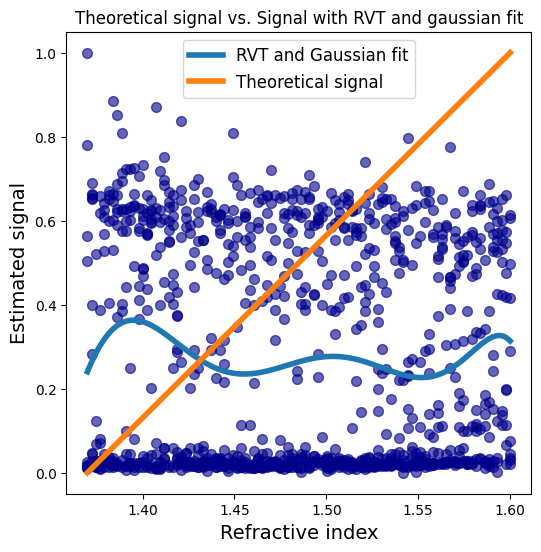

In [114]:
plt.figure(figsize=(6, 6))
plt.scatter(riis, signal_sum_gauss_fix_radius, color="darkblue", alpha=0.6, s=50)

x_axis = np.linspace(riis.min(), riis.max(), 200)

#Polynomial line for gaussian and RVT fit
coefficients = np.polyfit(riis, signal_sum_gauss_fix_radius, 7)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="-", linewidth=4, label="RVT and Gaussian fit")

#Polynomial line for theoretical
coefficients = np.polyfit(riis, theoretical_signal, 7)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="-", linewidth=4, label="Theoretical signal")


plt.xlabel("Refractive index", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical signal vs. Signal with RVT and gaussian fit")

Text(0.5, 1.0, 'Theoretical Signal vs. Signal estimated with a 2DCNN')

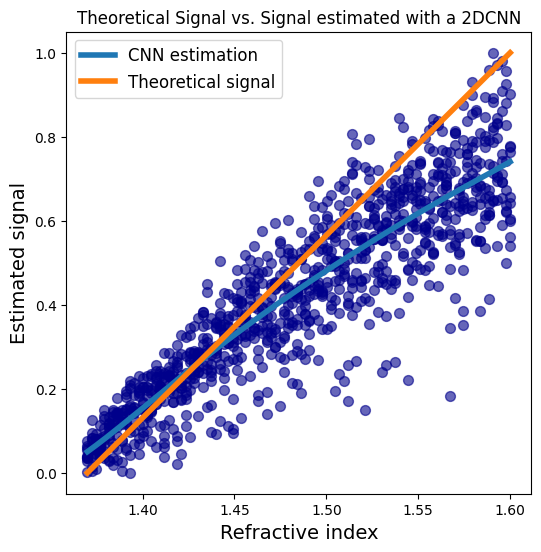

In [115]:
plt.figure(figsize=(6, 6))
plt.scatter(riis, signal_sum_cnn_fix_radius, color="darkblue", alpha=0.6, s=50)

x_axis = np.linspace(riis.min(), riis.max(), 200)

#Polynomial line for CNN fit
coefficients = np.polyfit(riis, signal_sum_cnn_fix_radius, 7)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="-", linewidth=4, label="CNN estimation")

#Polynomial line for theoretical
coefficients = np.polyfit(riis, theoretical_signal, 7)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="-", linewidth=4, label="Theoretical signal")

plt.xlabel("Refractive index", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical Signal vs. Signal estimated with a 2DCNN")

## 4. Combining detection and quantification in Quantitative field imaging
xxx

Text(0.5, 1.0, 'Ground truth detections and Polarizability')

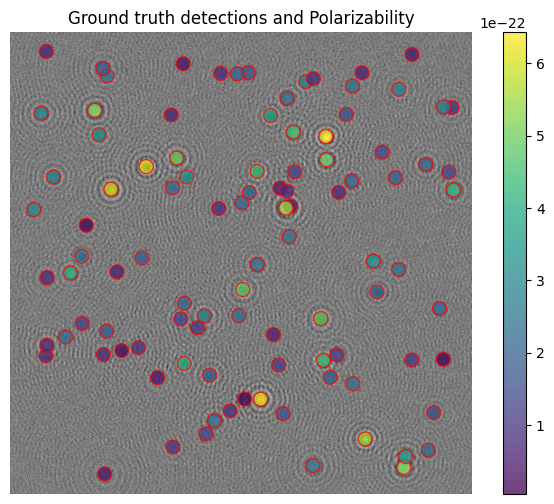

In [116]:
plt.figure(figsize=(8, 6))
plt.imshow(data[...,0], cmap="gray")
plt.scatter(labels[:,1], labels[:,0], s = 100, c = signal_rois, cmap = "viridis", edgecolors='r', alpha = 0.75)
plt.colorbar()
plt.axis("off")
plt.title("Ground truth detections and Polarizability")

### 4.1 RVT and Gaussian fit for particle detection and quantification

In [117]:
def rvt_gauss_full_frame_pipeline(data, rmin = 4, rmax = 25, th_scale = 0.3, min_distance = 7, padsize = 20):

    #Detect particles with RVT
    detections = rvt_pipeline(
        data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance
        )
    
    #If no detections, throw error.
    if len(detections) > 0:
        
        #Check so detections is not out of bounds
        detections = detections[(detections[:,0] > padsize) & (detections[:,0] < data.shape[0] - padsize) & 
                                (detections[:,1] > padsize) & (detections[:,1] < data.shape[1] - padsize)]

        #Get the signals
        signals = np.array([radial_variance_gaussian(roi, rmin = 3, rmax = 15, binary_gauss=True) for roi in get_rois(data, detections, padsize)])

        return detections, signals
    else:
        print("No detections")

In [118]:
detections, signals = rvt_gauss_full_frame_pipeline(data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance, padsize = 20)

Text(0.5, 1.0, 'Detections with RVT and Gaussian fit on full frame')

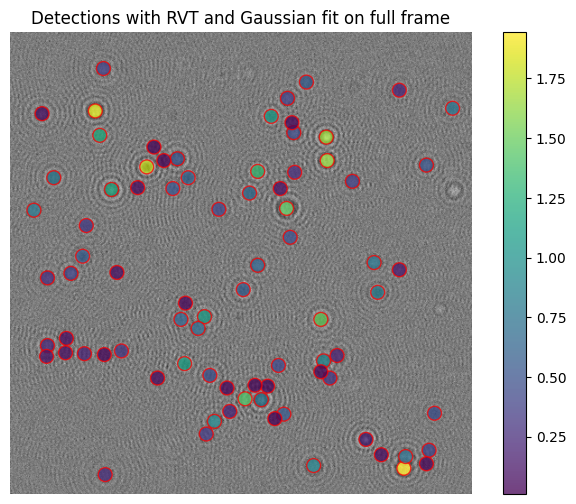

In [119]:
plt.figure(figsize=(8, 6))
plt.imshow(data[...,0], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, c = signals, cmap = "viridis", edgecolors='r', alpha = 0.75)
plt.colorbar()
plt.axis("off")
plt.title("Detections with RVT and Gaussian fit on full frame")


### 4.2 LodeSTAR and 2DCNN for particle detection and quantification
xxx

In [120]:
def LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha = 0.5, beta = 0.5, cutoff = 0.95, padsize = 20):

    #Transform data to a Tensor
    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()

    #Detect particles with LodeSTAR
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                    mode="quantile", cutoff=cutoff)[0]
    
    #If no detections, throw error.
    if len(detections) > 0:
        
        #Check so detections is not out of bounds
        detections = detections[(detections[:,0] > padsize) & (detections[:,0] < data.shape[0] - padsize) & 
                                (detections[:,1] > padsize) & (detections[:,1] < data.shape[1] - padsize)]

        #Get the signals
        signals = np.array([cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float()).detach().numpy()[0, 0] for roi in get_rois(data, detections, padsize)])

        return detections, signals

    else:
        print("No detections")

In [121]:
detections, signals = LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha = alpha, beta = beta, cutoff = cutoff, padsize = 20)

Text(0.5, 1.0, 'Detections with LodeSTAR and 2DCNN on full frame')

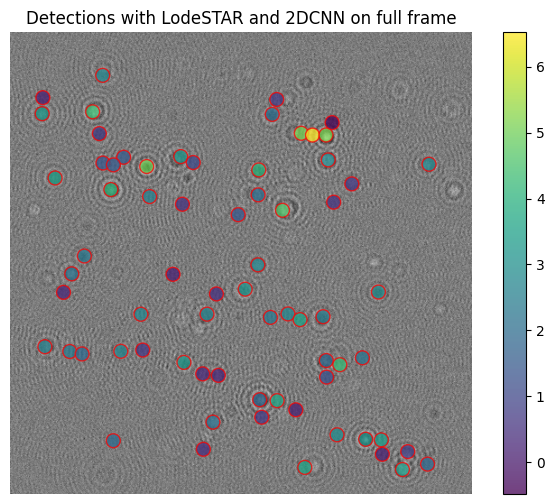

In [122]:
plt.figure(figsize=(8, 6))
plt.imshow(data[...,0], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, c = signals, cmap = "viridis", edgecolors='r', alpha = 0.75)
plt.colorbar()
plt.axis("off")
plt.title("Detections with LodeSTAR and 2DCNN on full frame")